In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import scipy
from sklearn.preprocessing import StandardScaler
from scipy import signal
from scipy import fft
from scipy.fft import fft, ifft, fftfreq
import matplotlib
import matplotlib. pyplot as plt
from sklearn.preprocessing import RobustScaler


In [22]:
df = pd.read_csv('/content/sample.csv') # change file name acc. to your file as "('/content/"Your_file_name.csv")"
df

,2023-12-06 15:03:53.908288,1019
0,2023-12-06 15:03:53.908288,1019
1,2023-12-06 15:03:53.908288,1018
2,2023-12-06 15:03:53.908288,775
3,2023-12-06 15:03:53.908288,377
4,2023-12-06 15:03:53.908288,5
...,...,...
1505472,2023-12-06 17:22:20.208483,5
1505473,2023-12-06 17:22:20.208483,3
1505474,2023-12-06 17:22:20.208483,4
1505475,2023-12-06 17:22:20.208483,641


# **Change the Labeling according to your data here **

In [23]:
df.loc[:750000,'label'] = 0 # here we have half data point for relax and other half of attentive state
df.loc[750000:,'label'] = 1

In [24]:
df.isnull().sum()

2023-12-06 15:03:53.908288    0
1019                          0
label                         0
dtype: int64

In [25]:
df.drop(df.index[150000:310001], inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(df.index[600000:750000], inplace=True)
#df = df.loc[600000:]
df.reset_index(drop=True, inplace=True)


In [26]:

df.drop(columns=df.columns[0], axis=1, inplace=True)
df

,1019,label
0,1019,0.0
1,1018,0.0
2,775,0.0
3,377,0.0
4,5,0.0
...,...,...
1195471,5,1.0
1195472,3,1.0
1195473,4,1.0
1195474,641,1.0


In [27]:
df.columns = ['raw_eeg', 'label']
df

,raw_eeg,label
0,1019,0.0
1,1018,0.0
2,775,0.0
3,377,0.0
4,5,0.0
...,...,...
1195471,5,1.0
1195472,3,1.0
1195473,4,1.0
1195474,641,1.0


In [28]:
data = df['raw_eeg']
labels_old = df['label']



sampling_rate = 512

notch_freq = 50.0  # for the notch filter
lowcut, highcut = 0.5, 30.0  # for the bandpass filter

#  notch filter
nyquist = (0.5 * sampling_rate)
notch_freq_normalized = notch_freq / nyquist
b_notch, a_notch = signal.iirnotch(notch_freq_normalized, Q=0.05, fs=sampling_rate)

#  bandpass filter
lowcut_normalized = lowcut / nyquist
highcut_normalized = highcut / nyquist
b_bandpass, a_bandpass = signal.butter(4, [lowcut_normalized, highcut_normalized], btype='band')

features = []
labels = []
additional_features_list = []

def calculate_psd_features(segment, sampling_rate):
    f, psd_values = scipy.signal.welch(segment, fs=sampling_rate, nperseg=len(segment))

    alpha_indices = np.where((f >= 8) & (f <= 13))
    beta_indices = np.where((f >= 14) & (f <= 30))
    theta_indices = np.where((f >= 4) & (f <= 7))
    delta_indices = np.where((f >= 0.5) & (f <= 3))

    energy_alpha = np.sum(psd_values[alpha_indices])
    energy_beta = np.sum(psd_values[beta_indices])
    energy_theta = np.sum(psd_values[theta_indices])
    energy_delta = np.sum(psd_values[delta_indices])

    # Calculate the alpha-beta ratio feature
    alpha_beta_ratio = energy_alpha / energy_beta

    return {
        'E_alpha': energy_alpha,
        'E_beta': energy_beta,
        'E_theta': energy_theta,
        'E_delta': energy_delta,
        'alpha_beta_ratio': alpha_beta_ratio
    }

def calculate_additional_features(segment, sampling_rate):
    f, psd = scipy.signal.welch(segment, fs=sampling_rate, nperseg=len(segment))

    # Peak frequency
    peak_frequency = f[np.argmax(psd)]

    # Spectral centroid
    spectral_centroid = np.sum(f * psd) / np.sum(psd)

    # Spectral slope
    log_f = np.log(f[1:])
    log_psd = np.log(psd[1:])
    spectral_slope = np.polyfit(log_f, log_psd, 1)[0]

    return {
        'peak_frequency': peak_frequency,
        'spectral_centroid': spectral_centroid,
        'spectral_slope': spectral_slope
    }


for i in range(0, len(data) - 512, 256):
    segment = data.loc[i:i+512]
    segment = pd.to_numeric(segment, errors='coerce')

    #  notch filter
    segment = signal.filtfilt(b_notch, a_notch, segment)

    #  bandpass filter
    segment = signal.filtfilt(b_bandpass, a_bandpass, segment)


    segment_features = calculate_psd_features(segment,512)
    additional_features = calculate_additional_features(segment, 512)

    segment_features = {**segment_features, **additional_features}

    features.append(segment_features)
    labels.append(labels_old[i])

X = np.array(features)
y = np.array(labels)

In [29]:
#features
segment_features

{'E_alpha': 1.9965219915459993,
 'E_beta': 2.4439407530981816,
 'E_theta': 1.3724019268457903,
 'E_delta': 8186.4238221398155,
 'alpha_beta_ratio': 0.8169273289522302,
 'peak_frequency': 0.9980506822612085,
 'spectral_centroid': 0.7650259015863428,
 'spectral_slope': -7.815465393226696}

In [30]:
columns = ['E_alpha', 'E_beta', 'E_theta', 'E_delta', 'alpha_beta_ratio','peak_frequency','spectral_centroid','spectral_slope']

# Create a DataFrame
df = pd.DataFrame(features, columns=columns)

df['label'] = y


In [31]:
df.describe()

,E_alpha,E_beta,E_theta,E_delta,alpha_beta_ratio,peak_frequency,spectral_centroid,spectral_slope,label
count,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000
mean,2.009572,3.673032,3.339801,8773.290378,0.704970,0.986719,1.134640,-7.931299,0.506213
std,7.427951,26.774824,4.632311,5258.831012,0.633787,0.109715,0.934564,0.289326,0.500015
min,0.081399,0.641251,0.094121,63.239436,0.034544,0.000000,0.729604,-11.430510,0.000000
25%,0.842783,1.990922,1.628328,3976.140396,0.328822,0.998051,0.796867,-8.041740,0.000000
50%,1.360261,2.559893,2.208598,8761.566576,0.534737,0.998051,0.815698,-7.835697,1.000000
75%,2.232213,3.293316,3.234129,13532.011176,0.877475,0.998051,1.004499,-7.731166,1.000000
max,321.134355,1249.991881,104.782368,24698.594442,15.166169,1.996101,16.334662,-7.457651,1.000000


In [32]:
#df.to_csv('ready.csv')

In [33]:
scaler = StandardScaler()
#scaler = RobustScaler()
X_scaled = scaler.fit_transform(df.drop('label', axis=1))
df_scaled = pd.DataFrame(X_scaled, columns=columns)

# Add labels to the DataFrame
df_scaled['label'] = df['label']

In [34]:
#df_scaled
X_scaled

array([[-0.0581216 ,  0.06158493,  0.74080987, ...,  0.10329461,
        -0.35500709, -0.20069946],
       [-0.08025998,  0.11452358,  0.03610116, ...,  0.10329461,
        -0.35242756,  0.19412208],
       [ 0.0663437 ,  0.20967818, -0.11496169, ...,  0.10329461,
        -0.35108078, -0.60971297],
       ...,
       [-0.13180551, -0.10239554, -0.38187053, ...,  0.10329461,
        -0.35516565,  1.11553198],
       [ 0.00744023, -0.00265182, -0.25626959, ...,  0.10329461,
        -0.38506616,  0.94544488],
       [-0.001757  , -0.04590966, -0.42475764, ...,  0.10329461,
        -0.39553658,  0.40039916]])

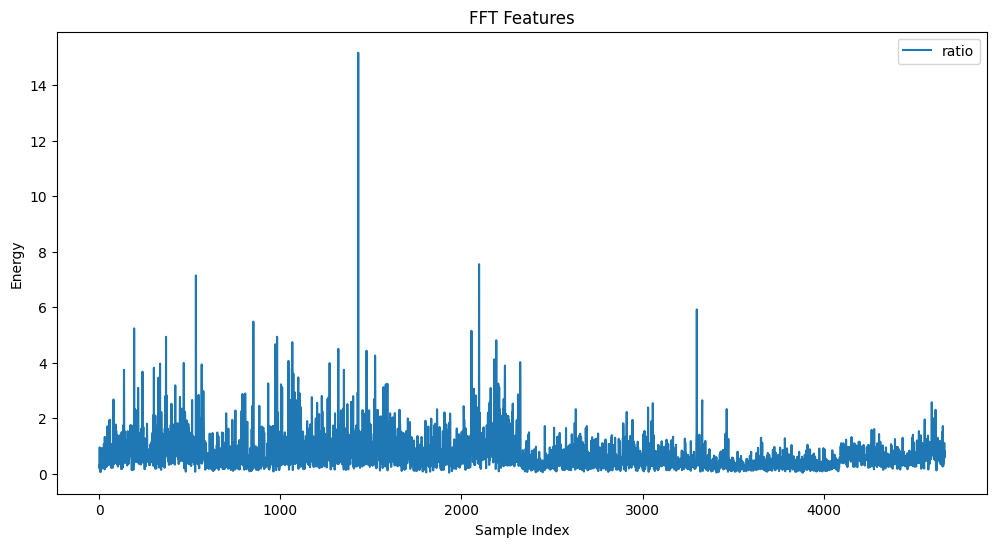

In [35]:
import matplotlib.pyplot as plt



# Plot FFT features
plt.figure(figsize=(12, 6))
#plt.plot(df.index, df['E_alpha'], label='Alpha Energy')
#plt.plot(df.index, df['E_beta'], label='Beta Energy')
###plt.plot(df.index, df['E_theta'], label='theta Energy')
#plt.plot(df.index, df['E_delta'], label='delta Energy')

plt.plot(df.index, df['alpha_beta_ratio'], label='ratio')

plt.xlabel('Sample Index')
plt.ylabel('Energy')
plt.title('FFT Features')
plt.legend()
plt.show()




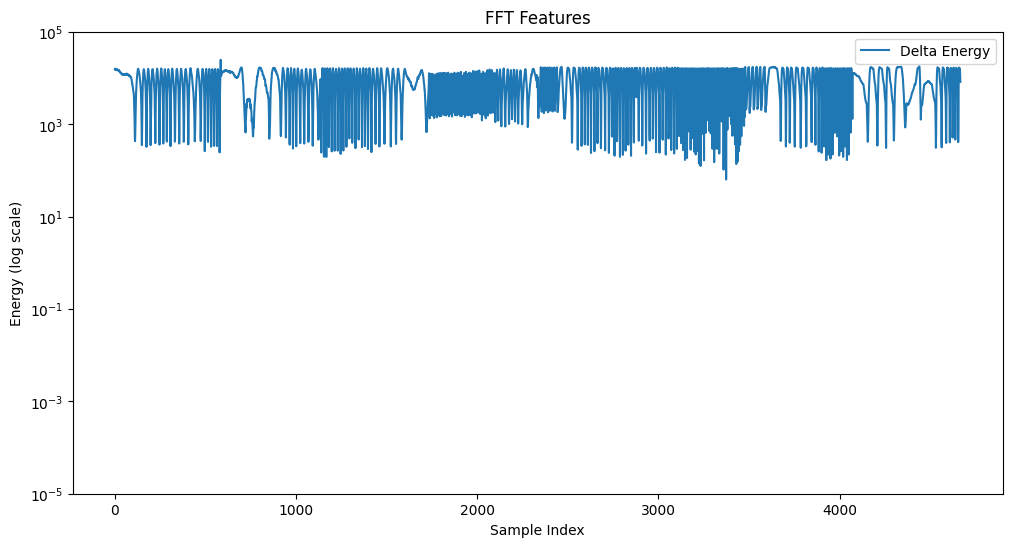

In [36]:
import matplotlib.pyplot as plt

# Plot FFT features
plt.figure(figsize=(12, 6))
#plt.plot(df.index, df['E_alpha'], label='Alpha Energy')
#plt.plot(df.index, df['E_beta'], label='Beta Energy')
#plt.plot(df.index, df['E_theta'], label='Theta Energy')
plt.plot(df.index, df['E_delta'], label='Delta Energy')
#plt.plot(df.index, df['alpha_beta_ratio'], label='Alpha/Beta Ratio')

plt.yscale('log')

threshold = 1e5
plt.ylim([1e-5, threshold])

plt.xlabel('Sample Index')
plt.ylabel('Energy (log scale)')
plt.title('FFT Features')
plt.legend()
plt.show()


In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled.drop('label', axis=1), df_scaled['label'], test_size=0.2, random_state=42)

#clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf = SVC(probability=True, random_state=42)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy}")

Classification Accuracy: 0.7644539614561028


In [51]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

X = df_scaled.drop('label', axis=1)
y = df_scaled['label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

svc = SVC(probability=True)

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

model = grid_search.best_estimator_
y_pred = model.predict(X_test)
test_accuracy = model.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_accuracy))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.80
Test set accuracy: 0.80


In [52]:
X_test

,E_alpha,E_beta,E_theta,E_delta,alpha_beta_ratio,peak_frequency,spectral_centroid,spectral_slope
2776,-0.154285,-0.023195,-0.183891,0.702571,-0.665892,0.103295,-0.348098,0.776417
1634,0.254435,0.034363,1.548103,-0.243915,0.227228,0.103295,-0.353993,-0.757227
1074,0.686241,-0.024282,2.786271,0.033485,2.597116,0.103295,-0.319526,-0.172056
2080,0.133659,-0.069330,-0.196356,0.642051,1.494996,0.103295,-0.397353,0.566668
4060,-0.042507,-0.020141,1.005983,-1.393134,-0.259514,0.103295,0.794821,-1.236599
...,...,...,...,...,...,...,...,...
2856,0.004744,-0.022892,-0.034927,1.378192,-0.058028,0.103295,-0.342686,0.341177
4236,-0.121318,-0.063296,0.404284,0.857074,-0.228297,0.103295,-0.361728,0.625248
831,-0.125314,-0.021191,-0.480296,-0.385596,-0.564279,0.103295,-0.360629,-0.430401
4099,-0.030228,-0.023393,0.395216,0.417689,-0.187907,0.103295,-0.381883,0.437801


In [53]:
import pickle

model_filename = 'model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(model, file)


In [54]:
import pickle

scaler_filename = 'scaler.pkl'

with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)


In [55]:
probabilities = model.predict_proba(X_test)[:,1]
print(f"Class Probabilities: {probabilities}")

Class Probabilities: [7.50583959e-01 8.27915411e-02 8.66548779e-02 6.65624147e-02
 5.16667129e-02 5.65401577e-01 1.65249130e-02 6.88159388e-01
 6.99862431e-02 5.28316710e-01 7.46590304e-01 3.56943533e-01
 3.69652464e-01 7.38672451e-01 8.56219757e-01 9.28235932e-01
 9.61254634e-01 8.12498000e-01 1.18872741e-02 6.64913050e-01
 8.47551978e-01 5.14942311e-01 9.19191304e-01 9.59751290e-03
 9.33730567e-01 8.05905981e-01 8.34467840e-01 3.11596101e-01
 5.93659932e-01 8.29243135e-01 8.12330253e-02 1.56807809e-01
 6.51244951e-01 9.06020540e-01 3.87115863e-02 7.62868553e-02
 8.46982701e-01 1.55544270e-01 7.56246036e-01 8.72547785e-01
 8.43229263e-01 9.39590725e-01 7.80841402e-01 8.05901533e-01
 6.00606017e-02 8.04566523e-01 3.77836613e-02 8.07462429e-01
 3.40055427e-02 5.93714296e-02 2.03838890e-01 6.69115442e-02
 1.09756604e-01 9.14586701e-01 8.17705561e-01 7.38300884e-01
 7.69370666e-01 2.03889102e-01 7.26268450e-03 9.35898607e-01
 9.19601167e-01 8.85565513e-01 4.46034495e-01 6.80885272e-02
 1.

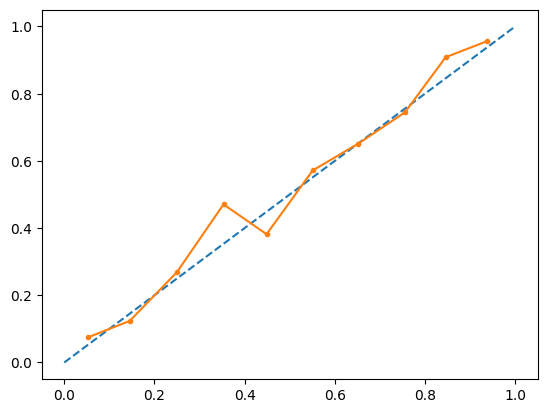

In [56]:
from sklearn.calibration import calibration_curve
fop, mpv = calibration_curve(y_test, probabilities, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

In [57]:
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(model, cv=3)
calibrator.fit(X_train,y_train)
yhat = calibrator.predict(X_test)

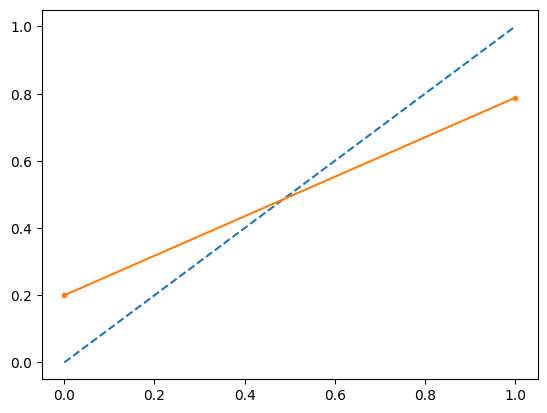

In [58]:
fop, mpv = calibration_curve(y_test, yhat, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

In [59]:
accuracy = accuracy_score(y_test, yhat)
print(f"Classification Accuracy: {accuracy}")

Classification Accuracy: 0.7933618843683083


In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_true = df_scaled['label']
y_pred = model.predict(X_scaled)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(y_true, y_pred)
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_true, y_pred)
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(y_true, y_pred)
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Accuracy: 0.8211
Precision: 0.8029
Recall: 0.8570
F1 Score: 0.8291
Confusion Matrix:
[[1808  497]
 [ 338 2025]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81      2305
         1.0       0.80      0.86      0.83      2363

    accuracy                           0.82      4668
   macro avg       0.82      0.82      0.82      4668
weighted avg       0.82      0.82      0.82      4668

